# Librairies Importation

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Import Files

In [3]:
# Load the data
train = pd.read_csv('kaggle_data/train_x.csv')
train_labels = pd.read_csv('kaggle_data/train_y.csv')
val = pd.read_csv('kaggle_data/val_x.csv')
val_labels = pd.read_csv('kaggle_data/val_y.csv')

# Combine X and Y for easier processing
train = pd.concat([train, train_labels], axis=1)
val = pd.concat([val, val_labels], axis=1)

# Preprocessing

In [4]:
#Change type of string column to string
train['string'] = train['string'].astype(str)

<Axes: ylabel='Frequency'>

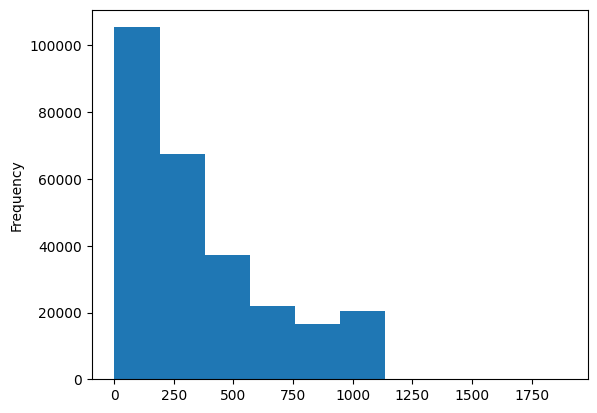

In [5]:
train['string'].str.len().plot(kind='hist')


In [6]:
# Preprocess the text data 
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train['string'].astype(str))

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train['string'].astype(str))
X_val_seq = tokenizer.texts_to_sequences(val['string'].astype(str))

# Pad sequences to ensure uniform length
max_length = 800  
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

In [7]:
X_train_padded

array([[ 84,  61, 119, ...,   0,   0,   0],
       [604, 118, 449, ...,   0,   0,   0],
       [ 10,  17,  42, ...,   0,   0,   0],
       ...,
       [ 42, 258,  32, ...,   0,   0,   0],
       [ 11,  51,  58, ...,   0,   0,   0],
       [ 10,  83,   2, ...,   0,   0,   0]], dtype=int32)

In [8]:
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 800, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 800, 64)           49408     
                                                                 
 dropout (Dropout)           (None, 800, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 701857 (2.68 MB)
Trainable params: 701857 (2.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Train the model
model_lstm.fit(X_train_padded, train['y'], epochs=5, validation_data=(X_val_padded, val['y']))


Epoch 1/5
8408/8408 [==============================] - 15018s 2s/step - loss: 0.3543 - accuracy: 0.8865 - val_loss: 0.3505 - val_accuracy: 0.8881
Epoch 2/5
8408/8408 [==============================] - 10699s 1s/step - loss: 0.3539 - accuracy: 0.8866 - val_loss: 0.3507 - val_accuracy: 0.8881
Epoch 3/5
3819/8408 [============>.................] - ETA: 40:28 - loss: 0.3543 - accuracy: 0.8863

In [ ]:
from sklearn.metrics import accuracy_score
# Predict on the validation set
val_predictions = model_lstm.predict(X_val_padded).round()

# Calculate accuracy for each subgroup and find the worst-group accuracy
# Adjust this code as needed to fit the challenge's specific evaluation criteria
subgroup_accuracies = []
for subgroup in ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']:
    subgroup_idx = val[subgroup] == 1
    subgroup_accuracy = accuracy_score(val.loc[subgroup_idx, 'y'], val_predictions[subgroup_idx])
    subgroup_accuracies.append(subgroup_accuracy)

worst_group_accuracy = min(subgroup_accuracies)
print(f"Worst-Group Accuracy: {worst_group_accuracy}")


In [ ]:
test_x = pd.read_csv('kaggle_data/test_x.csv')
X_test_seq = tokenizer.texts_to_sequences(test_x['string'].astype(str))
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Generate predictions
test_predictions = model_lstm.predict(X_test_padded).flatten()

# Prepare the submission file
submission = pd.DataFrame({
    'ID': test_x['index'],
    'pred': test_predictions
})
submission.to_csv('submissio_lstm.csv', index=False)
